In [ ]:
#| default_exp core

# core

> Core routines for shazbot

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export 
import torch
import torch.nn as nn
import torch.nn.functional  as F 
import torchaudio
from torchaudio import transforms as T
import accelerate
import tqdm
from pathlib import Path
import yaml
import os

## Audio utils

In [ ]:
#| export
def is_silence(
    audio,       # torch tensor of multichannel audio
    thresh=-70,  # threshold in dB below which we declare to be silence
    ):
    "checks if entire clip is 'silence' below some dB threshold"
    dBmax = 20*torch.log10(torch.flatten(audio.abs()).max()).cpu().numpy()
    return dBmax < thresh

In [ ]:
# code tests
x = torch.ones((2,10))
assert not is_silence(1e-3*x) # not silent
assert is_silence(1e-5*x) # silent
assert is_silence(1e-3*x, thresh=-50) # higher thresh

In [ ]:
#|export
def load_audio(
    filename:str,     # file to load
    sr=48000,         # sample rate to read/resample at 
    )->torch.tensor:
    "this loads an audio file as a torch tensor"
    audio, in_sr = torchaudio.load(filename)
    if in_sr != sr:
        print(f"Resampling {filename} from {in_sr} Hz to {sr} Hz",flush=True)
        resample_tf = T.Resample(in_sr, sr)
        audio = resample_tf(audio)
    return audio


def makedir(
    path:str,          # directory or nested directory
    ):
    "creates directories where they don't exist"
    if os.path.isdir(path): return  # don't make it if it already exists
    #print(f"  Making directory {path}")
    try:
        os.makedirs(path)  # recursively make all dirs named in path
    except:                # don't really care about errors
        pass

## Parallelism utils

In [ ]:
#|export 
def get_accel_config(filename='~/.cache/huggingface/accelerate/default_config.yaml'):
    "get huggingface accelerate config info"
    
    # first try to use the default file
    try:  
        filename = filename.replace('~', str(Path.home()))
        with open(filename, 'r') as file:
            ac =  yaml.safe_load(file)
    except OSError:
        ac = {}
        
    # then update using any environment variables
    if os.getenv('MAIN_PROCESS_IP') is not None: ac['main_process_ip'] = os.getenv('MAIN_PROCESS_IP')
    if os.getenv('MACHINE_RANK')    is not None: ac['machine_rank']    = os.getenv('MACHINE_RANK')
    if os.getenv('NUM_MACHINES')    is not None: ac['num_machines']    = os.getenv('NUM_MACHINES')
    if os.getenv('NUM_PROCESSES')   is not None: ac['num_processes']   = os.getenv('NUM_PROCESSES')

    return ac

In [ ]:
# test get_accel_config 
accel_config = get_accel_config()
print("accel_config =",accel_config)
if accel_config:
    print("port =",accel_config['main_process_port'])

accel_config = {'compute_environment': 'LOCAL_MACHINE', 'deepspeed_config': {}, 'distributed_type': 'MULTI_GPU', 'fsdp_config': {}, 'machine_rank': 0, 'main_process_ip': '', 'main_process_port': 12456, 'main_training_function': 'main', 'mixed_precision': 'fp16', 'num_machines': 4, 'num_processes': 32, 'use_cpu': False}
port = 12456


In [ ]:
#|export        
class HostPrinter():
    "lil accelerate utility for only printing on host node"
    def __init__(self, accelerator, tag='\033[96m', untag='\033[0m'): #added some colors
        self.accelerator, self.tag, self.untag = accelerator, tag, untag
    def __call__(self, s:str):
        if self.accelerator.is_main_process:
            print(self.tag + s + self.untag, flush=True)

In [ ]:
#test hostprinter
accelerator = accelerate.Accelerator()
device = accelerator.device
hprint = HostPrinter(accelerator)
hprint(f'Using device: {device}')

Using device: cuda


## Utils for PyTorch models

In [ ]:
#|export 
def save(accelerator, args, model, opt=None, epoch=None, step=None):
    "for checkpointing & model saves"
    accelerator.wait_for_everyone()
    filename = f'{args.name}_{step:08}.pth' if (step is not None) else f'{args.name}.pth'
    if accelerator.is_main_process:
        tqdm.write(f'Saving to {filename}...')
    obj = {'model': accelerator.unwrap_model(model).state_dict() }
    if opt is not None:   obj['opt'] = opt.state_dict()
    if epoch is not None: obj['epoch'] = epoch
    if step is not None:  obj['step'] = step
    accelerator.save(obj, filename)
    

def n_params(module):
    """Returns the number of trainable parameters in a module."""
    return sum(p.numel() for p in module.parameters())


def freeze(model):
    "freezes model weights; turns off gradient info "
    for param in model.parameters():  
        param.requires_grad = False

### Activations: Mish & Swish

In [ ]:
#|export 

# cf https://github.com/tyunist/memory_efficient_mish_swish
class Mish_func(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)


    
class Swish_func(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
    

class Swish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        pass
    def forward(self, input_tensor):
        return Swish_func.apply(input_tensor)

And let's see how those two functions compare

<matplotlib.legend.Legend>

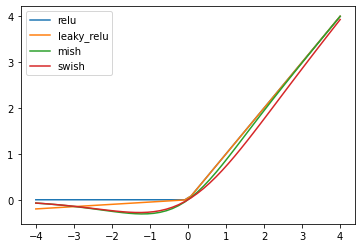

In [ ]:
import matplotlib.pyplot as plt

x = torch.linspace(-4,4,50)
mish = Mish()
swish = Swish()
plt.plot(x, x*(x>0), label='relu')
plt.plot(x, F.leaky_relu(x, negative_slope=0.05), label='leaky_relu')
plt.plot(x, mish(x), label='mish')
plt.plot(x, swish(x), label='swish')
plt.legend()